In [5]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import os
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [6]:
random_seed = 42
torch.manual_seed(random_seed)
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2)

In [7]:
AVAIL_GPUS, NUM_WORKERS

(1, 8)

In [3]:
dataset = MNIST(root="data/", transform=ToTensor())

In [4]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [8]:
batch_size = 128
train_loader = DataLoader(
    train_ds, batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size * 2, num_workers=NUM_WORKERS, pin_memory=True
)

images.shape: torch.Size([128, 1, 28, 28])


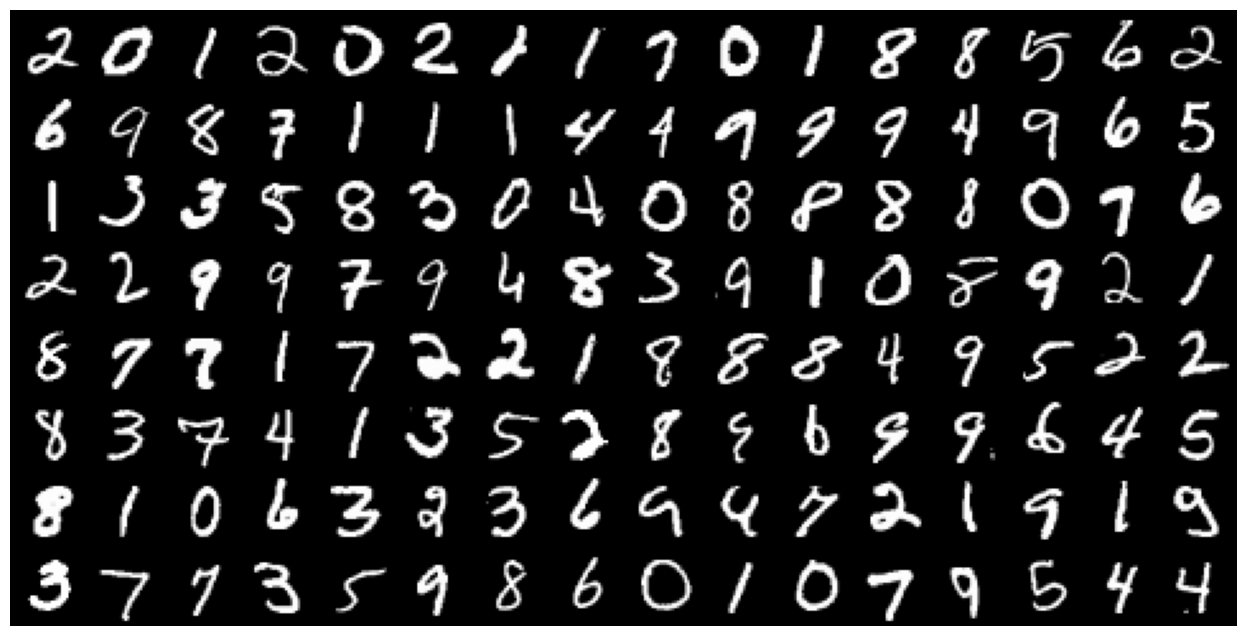

In [9]:
for images, _ in train_loader:
    print("images.shape:", images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [10]:
for images, labels in train_loader:
    print("images.shape:", images.shape)
    inputs = images.reshape(-1, 784)
    print("inputs.shape:", inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [11]:
input_size = inputs.shape[-1]
print(input_size)
hidden_size = 32

784


In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""

    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {"val_loss": loss, "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(
            "Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result["val_loss"], result["val_acc"]
            )
        )

In [14]:
input_size = 784  # 28*28
hidden_size = 32  # you can change this
num_classes = 10

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [20]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [21]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [22]:
class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [24]:
for xb, yb in val_loader:
    print("xb.device:", xb.device)
    print("yb:", yb)
    break

xb.device: cuda:0
yb: tensor([4, 3, 4, 9, 4, 6, 1, 6, 6, 6, 8, 8, 5, 8, 5, 1, 9, 8, 4, 1, 7, 5, 2, 7,
        6, 5, 1, 3, 5, 0, 2, 0, 1, 1, 2, 1, 7, 2, 7, 8, 3, 6, 8, 0, 4, 9, 8, 7,
        3, 0, 2, 2, 4, 3, 1, 3, 8, 6, 3, 2, 0, 9, 3, 1, 1, 4, 8, 0, 1, 2, 5, 8,
        8, 8, 9, 8, 8, 5, 6, 5, 2, 6, 1, 1, 2, 9, 1, 2, 1, 0, 3, 5, 7, 7, 0, 1,
        5, 0, 1, 5, 9, 3, 6, 8, 8, 6, 4, 2, 6, 9, 9, 6, 5, 9, 2, 4, 3, 1, 9, 1,
        8, 3, 6, 3, 7, 3, 1, 6, 9, 9, 0, 9, 1, 9, 8, 5, 2, 7, 4, 0, 1, 3, 1, 2,
        6, 5, 6, 8, 5, 6, 4, 5, 5, 5, 4, 5, 6, 3, 4, 6, 0, 1, 3, 9, 6, 7, 0, 6,
        2, 6, 7, 0, 3, 0, 0, 3, 1, 3, 5, 7, 3, 8, 2, 6, 5, 9, 2, 5, 4, 5, 9, 7,
        7, 9, 0, 3, 2, 1, 3, 5, 6, 6, 7, 4, 0, 3, 9, 6, 4, 7, 7, 7, 1, 1, 7, 9,
        3, 1, 3, 9, 9, 2, 5, 7, 8, 8, 4, 2, 2, 6, 9, 6, 2, 1, 4, 3, 5, 8, 3, 8,
        1, 6, 4, 9, 0, 3, 1, 1, 9, 5, 7, 3, 5, 6, 0, 6], device='cuda:0')


In [25]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [27]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.325589418411255, 'val_acc': 0.12050781399011612}]

In [28]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2674, val_acc: 0.9180
Epoch [1], val_loss: 0.1846, val_acc: 0.9438
Epoch [2], val_loss: 0.1592, val_acc: 0.9513
Epoch [3], val_loss: 0.1335, val_acc: 0.9592
Epoch [4], val_loss: 0.1750, val_acc: 0.9499


In [29]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1209, val_acc: 0.9627
Epoch [1], val_loss: 0.1221, val_acc: 0.9638
Epoch [2], val_loss: 0.1209, val_acc: 0.9630
Epoch [3], val_loss: 0.1195, val_acc: 0.9632
Epoch [4], val_loss: 0.1174, val_acc: 0.9641


Text(0.5, 1.0, 'Loss vs. No. of epochs')

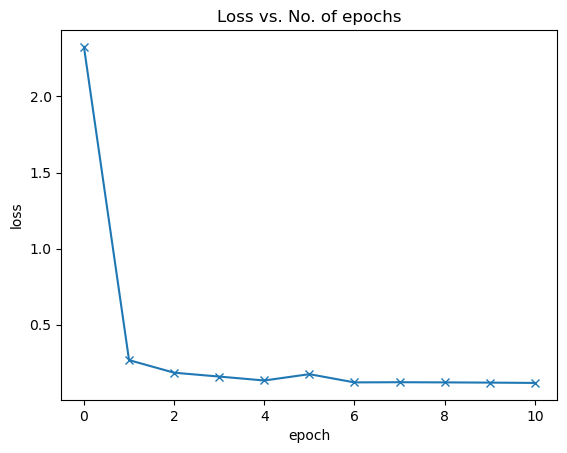

In [30]:
losses = [x["val_loss"] for x in history]
plt.plot(losses, "-x")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss vs. No. of epochs")

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

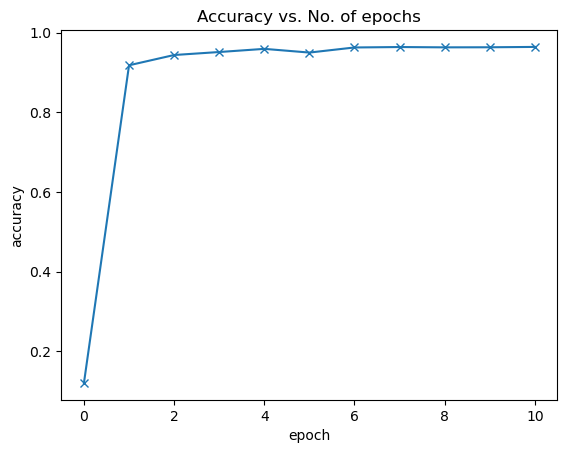

In [31]:
accuracies = [x["val_acc"] for x in history]
plt.plot(accuracies, "-x")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy vs. No. of epochs")

In [32]:
# Define test dataset
test_dataset = MNIST(root="data/", train=False, transform=ToTensor())

In [33]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 0 , Predicted: 0
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 5 , Predicted: 6
Label: 9 , Predicted: 9


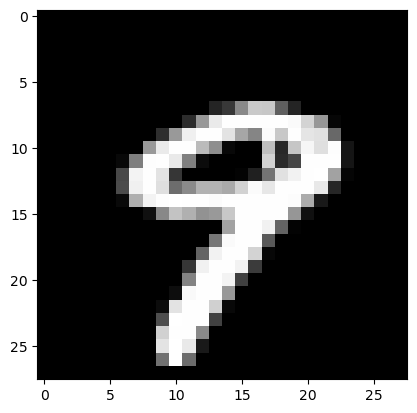

In [34]:
for i in range(10):
    img, label = test_dataset[i]
    plt.imshow(img[0], cmap="gray")
    print("Label:", label, ", Predicted:", predict_image(img, model))

In [35]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10301434248685837, 'val_acc': 0.96826171875}

accuracy is 96%
